# Demonstration of how to compute GoF scores

This notebook demonstrates how to compute the goodness-of-fit scores between two time series.

## 1. Import relevant libraries

In [1]:
%%capture
!pip install h5py

In [2]:
import h5py
import numpy as np
from PySeismoSoil.class_gof_scores import GOF_Scores

### 1.1. Useful function for HDF5 file visualization
The data for this example is stored in a hdf5 file, which is a format useful for organizing a large amount of data, but it is not required for generating goodness of fit scores.

In [3]:
def h5_tree(val, pre=''):
    items = len(val)
    for key, val in val.items():
        items -= 1
        if items == 0:
            # the last item
            if type(val) == h5py._hl.group.Group:
                print(pre + '└── ' + key)
                h5_tree(val, pre + '    ')
            else:
                print(pre + '└── ' + key + f' {val.shape}')
        else:
            if type(val) == h5py._hl.group.Group:
                print(pre + '├── ' + key)
                h5_tree(val, pre + '│   ')
            else:
                print(pre + '├── ' + key + f' {val.shape}')

## 2. Load and view dataset

In [4]:
# This command connects Python to the hdf5 file, which can then be
# interacted with using the 'hf' handle
with h5py.File(f'files/SSA_GANO_FNO_PySSL.h5', 'r') as hf:
    # Here we are just displaying the details of the file
    # There is one group, called "reverse_M7_rrup_12", which
    # contains two datasets, "GANO_FNO", and "GANO_PySeismoSoil".
    # Each dataset has 5 time histories of length 10,000 time steps.
    print(hf)
    h5_tree(hf)

    # We load the datasets into numpy arrays (h5py automatically does this
    # when you retrieve the data)
    data_true = hf[f'reverse_M7_rrup_12/GANO_PySeismoSoil'][:]
    data_model = hf[f'reverse_M7_rrup_12/GANO_FNO'][:]

<HDF5 file "SSA_GANO_FNO_PySSL.h5" (mode r)>
└── reverse_M7_rrup_12
    ├── GANO_FNO (5, 10000)
    └── GANO_PySeismoSoil (5, 10000)


## 3. Run Goodness-of-Fit Scoring

Goodness of Fit Scores
---------------------------------------
Normalized Arias Intensity (S1): -0.044
Normalized Energy Integral (S2): -0.026
      Peak Arias Intensity (S3): -0.266
      Peak Energy Integral (S4):  0.007
          RMS Acceleration (S5): -0.134
              RMS Velocity (S6):  0.003
          RMS Displacement (S7):  0.084
     Spectral Acceleration (S8): -0.172
           Fourier Spectra (S9): -0.489
---------------------------------------
Average Score: -0.115


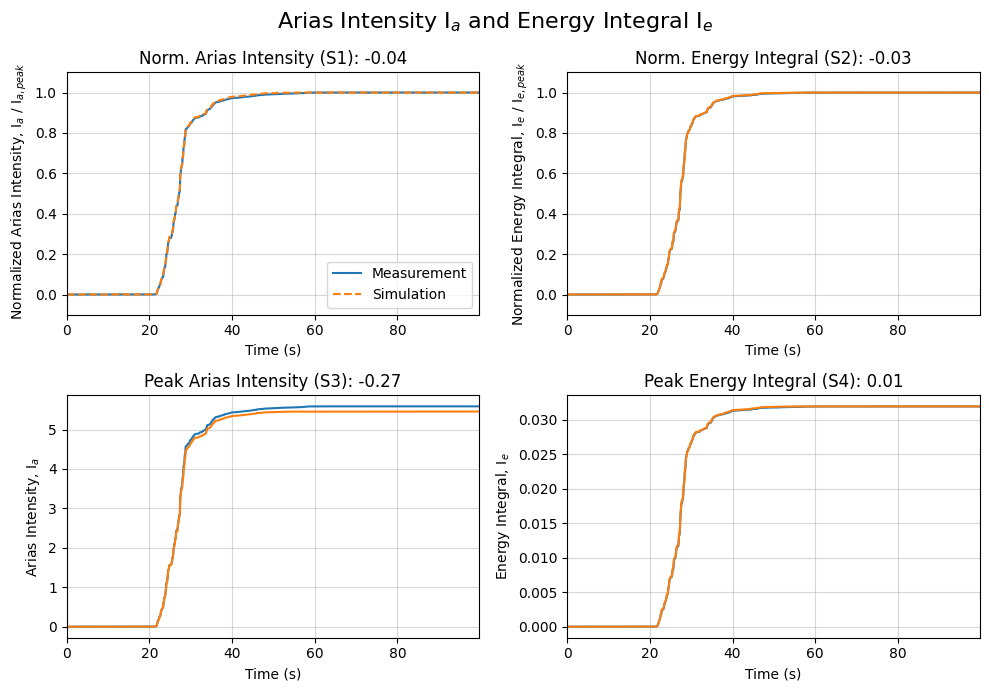

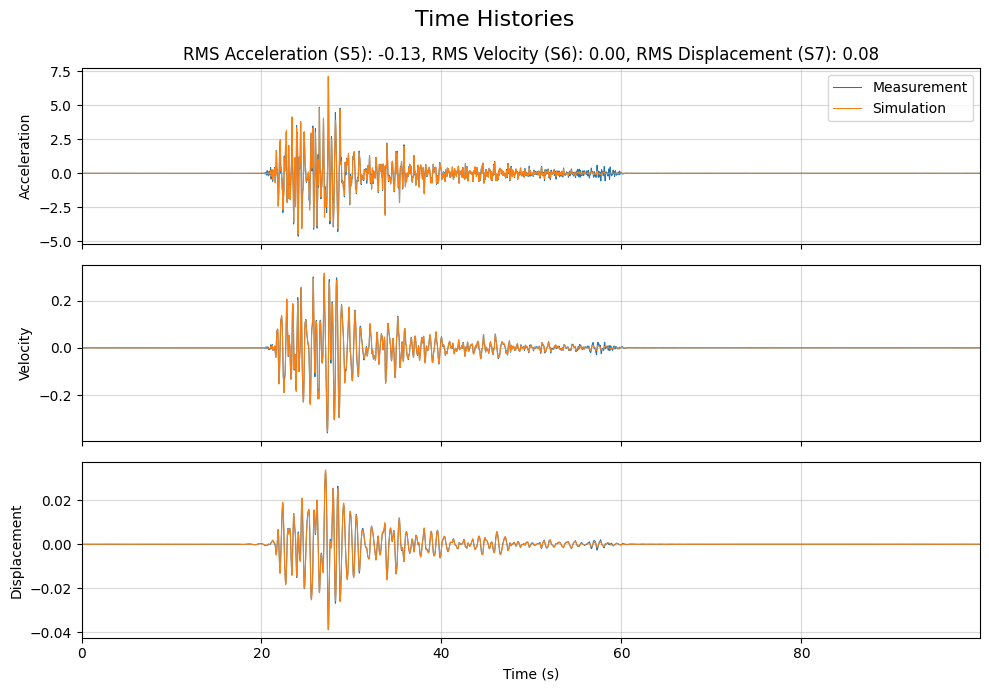

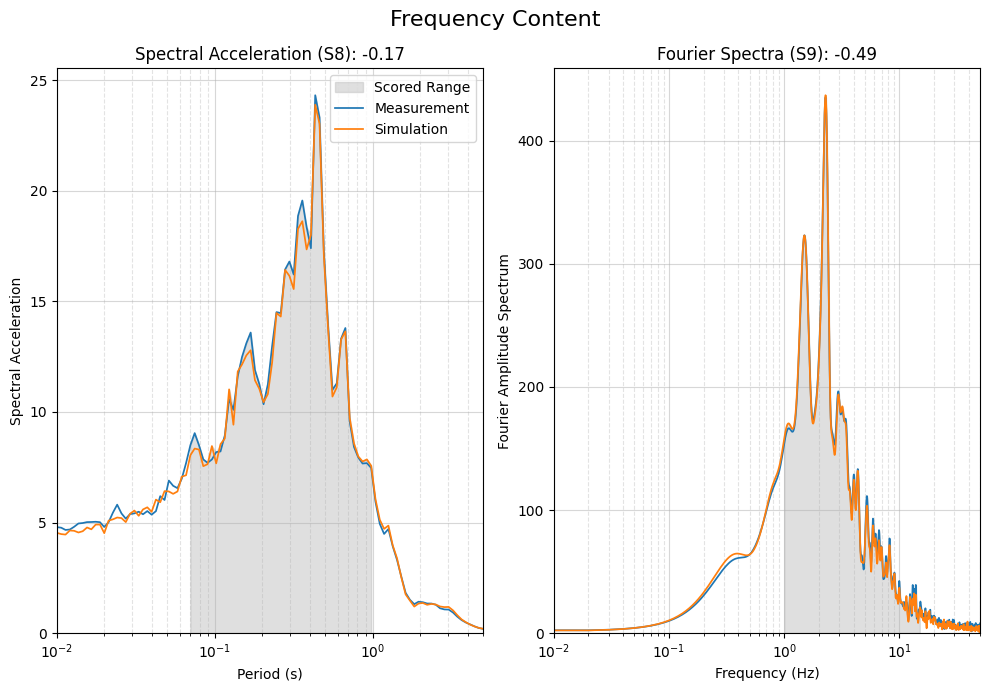

In [5]:
# We extract one pair of time histories from the datasets
ix = 0  # ix = 0 ... 4 (you can change this to compare different time series)
y_true = data_true[ix, :]
y_model = data_model[ix, :]

# We define a frequency range on which we want to evaluate two time histories
fmin = 1.0
fmax = 15.0

dt = 0.01  # Time step is 0.01s
T = y_true.shape[0]
t_array = (dt) * np.arange(1, T + 1)

# Create GOF_Scores object
# Each input numpy array should have two columns, where the
# first column contains the time vector and the second column
# contains the data.
measurement = np.column_stack((t_array, y_true))
simulation = np.column_stack((t_array, y_model))
myScore = GOF_Scores(measurement, simulation)

# Calculate scores and plot
score = myScore.calc_scores(fmin=fmin, fmax=fmax, show_fig=True, verbose=True)

# Batch GoF Score Computation

In [6]:
# Import statement
from PySeismoSoil.class_gof_scores import Batch_GOF_Scores

# We define a list to hold all of the GOF score objects
scoreList = []

# Time array corresponding to the data
dt = 0.01  # Time step is 0.01s
T = 10000  # Length of each time series
t_array = (dt) * np.arange(1, T + 1)

# Load hdf5 dataset
with h5py.File(f'files/SSA_GANO_FNO_PySSL.h5', 'r') as hf:
    print(hf)
    h5_tree(hf)

    # Set up multiple score objects
    for ind in range(5):
        # Here we are loading each time series from the hdf5 file individually as we need it
        measurement = np.column_stack((
            t_array,
            hf[f'reverse_M7_rrup_12/GANO_PySeismoSoil'][ind, :],
        ))
        simulation = np.column_stack((
            t_array,
            hf[f'reverse_M7_rrup_12/GANO_FNO'][ind, :],
        ))

        # Create score object
        score_obj = GOF_Scores(measurement, simulation)

        # Add to list
        scoreList.append(score_obj)

# Batch scoring object
batch_scores = Batch_GOF_Scores(scoreList)

# Run the GoF scoring batch in parallel
calculated_batch_scores = batch_scores.run(
    parallel=True,
    n_cores=4,
    options=dict(fmin=1.0, fmax=15.0),
)

# We can look at the results of each GoF score object
for score in calculated_batch_scores:
    print(score)

<HDF5 file "SSA_GANO_FNO_PySSL.h5" (mode r)>
└── reverse_M7_rrup_12
    ├── GANO_FNO (5, 10000)
    └── GANO_PySeismoSoil (5, 10000)

Goodness of Fit Scores
---------------------------------------
Normalized Arias Intensity (S1): -0.044
Normalized Energy Integral (S2): -0.026
      Peak Arias Intensity (S3): -0.266
      Peak Energy Integral (S4):  0.007
          RMS Acceleration (S5): -0.134
              RMS Velocity (S6):  0.003
          RMS Displacement (S7):  0.084
     Spectral Acceleration (S8): -0.172
           Fourier Spectra (S9): -0.489
---------------------------------------
Average Score: -0.115


Goodness of Fit Scores
---------------------------------------
Normalized Arias Intensity (S1): -0.014
Normalized Energy Integral (S2): -0.033
      Peak Arias Intensity (S3): -0.219
      Peak Energy Integral (S4):  0.169
          RMS Acceleration (S5): -0.110
              RMS Velocity (S6):  0.084
          RMS Displacement (S7):  0.127
     Spectral Acceleration (S8): -0.